In [1]:
import pandas as pd
import numpy as np
import numpy.typing as npt


from matplotlib import pyplot as plt
from tqdm import tqdm
from utility.types import RebalanceFrequencyEnum, AllocationMethodsEnum

from data.universe import Universe
from data.benchmark import Benchmark
from backtest.backtest import Backtester
from portfolio_management.market_regime import detect_market_regime

In [4]:
bench = Benchmark()
# universe = Universe.get_universe_returns()
# universe
benchmark = bench.get_benchmark_returns_data()
benchmark

,OISESTR,SPX,SX5T
Date,,,
2019-10-01,-0.000022,0.000000,0.000000
2019-10-02,-0.000022,-0.017903,-0.029827
2019-10-03,-0.000022,0.007972,0.001189
2019-10-04,-0.000022,0.014217,0.008586
2019-10-07,-0.000022,-0.004478,0.007117
...,...,...,...
2024-02-09,0.000155,0.000000,0.000000
2024-02-12,0.000155,0.004788,0.007551
2024-02-13,0.000155,-0.013674,-0.012024


In [5]:
universe = Universe().get_universe_returns()
universe

,MONTAIRE,ETF_GROWTH,ETF_VALUE,ETF_CAC,ETF_SPX
date,,,,,
2016-06-01,0.000000,0.000000,0.000000,0.000000,0.000000
2016-06-02,-0.000010,0.004860,0.004419,0.000442,0.003586
2016-06-03,0.000000,-0.010231,-0.005313,-0.009287,-0.017370
2016-06-06,-0.000020,-0.001316,0.014437,0.003236,0.005692
2016-06-07,0.000000,0.006586,0.005512,0.011012,0.005440
...,...,...,...,...,...
2024-02-22,0.000109,0.010694,0.004420,0.012323,0.020330
2024-02-23,0.000119,0.004429,0.000000,0.006920,0.004213
2024-02-26,0.000307,-0.003491,-0.004490,-0.004200,-0.004097


In [6]:



REGIMES = detect_market_regime(universe[["ETF_SPX"]].to_numpy())

c:\_sharedFS\Ecole\Cross-Asset-Investment-Solutions\Cross-Asset-Investment-Solutions\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\_sharedFS\Ecole\Cross-Asset-Investment-Solutions\Cross-Asset-Investment-Solutions\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


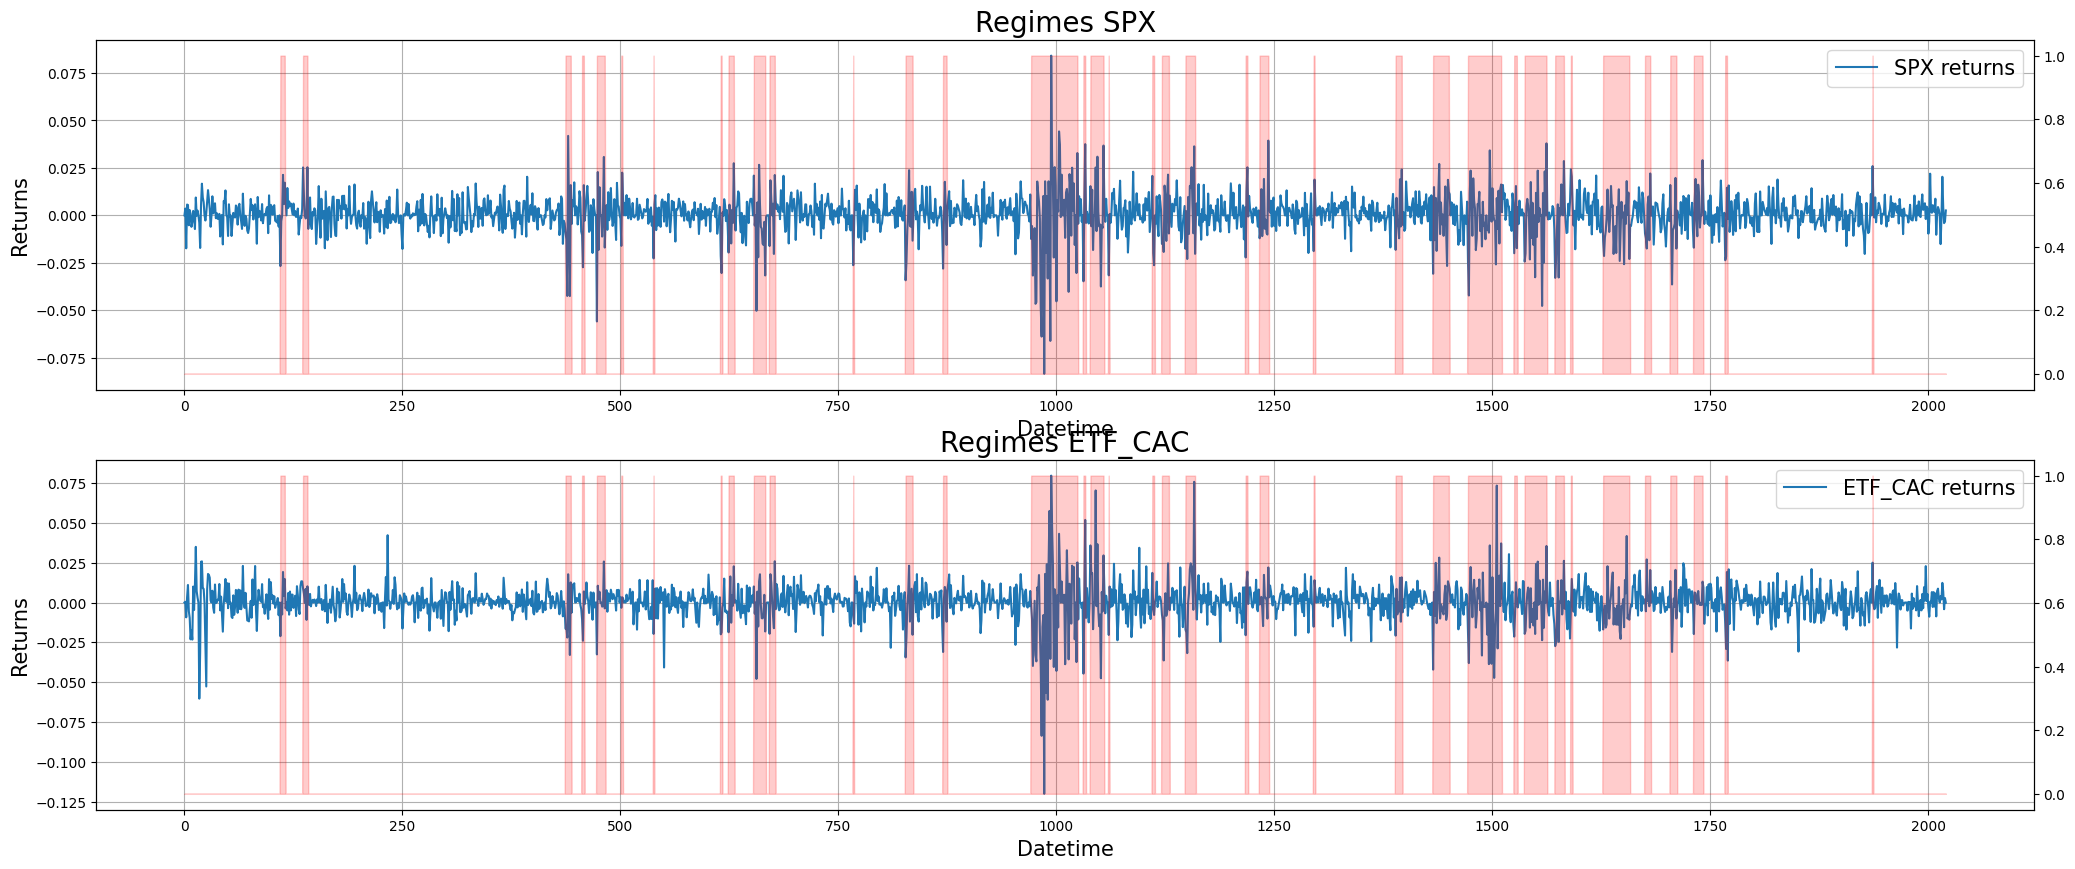

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))
ax_l = ax[0].twinx()
ax_l.fill_between(np.array(range(universe.ETF_SPX.shape[0])), REGIMES,alpha=0.2, color='red')
ax[0].plot(np.array(range(universe.ETF_SPX.shape[0])), universe.ETF_SPX, label="SPX returns")
ax[0].set_xlabel("Datetime", fontsize=15)
ax[0].set_ylabel("Returns", fontsize=15)
ax[0].set_title("Regimes SPX", fontsize=20)
ax[0].grid()
ax[0].legend(fontsize=15)

ax_l = ax[1].twinx()
ax_l.fill_between(np.array(range(universe.ETF_CAC.shape[0])), REGIMES,alpha=0.2, color='red')
ax[1].plot(np.array(range(universe.ETF_CAC.shape[0])), universe.ETF_CAC, label="ETF_CAC returns")
ax[1].set_xlabel("Datetime", fontsize=15)
ax[1].set_ylabel("Returns", fontsize=15)
ax[1].set_title("Regimes ETF_CAC", fontsize=20)
ax[1].grid()
ax[1].legend(fontsize=15)

In [ ]:
plt.figure(figsize=(25, 10))
plt.plot(ptf_and_bench_perf["benchmark_returns"], label="Benchmark")
plt.plot(ptf_and_bench_perf["ptf_returns_max_sharpe"], label="Max Sharpe Portfolio")
plt.plot(
    ptf_and_bench_perf["ptf_returns_equal_weight"], label="Equally weighted Portfolio"
)
plt.xlabel("Datetime", fontsize=18)
plt.ylabel("Performance", fontsize=18)
plt.title(
    "Benchmark vs Max Sharpe Portfolio vs Equally weighted Portfolio",
    fontsize=20,
)
plt.grid()
plt.legend(fontsize=15)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].stackplot(
    ptf_weights_max_sharpe.index,
    ptf_weights_max_sharpe.to_numpy().T,
)
ax[0].set_xlabel("Datetime", fontsize=18)
ax[0].set_ylabel("Weights", fontsize=18)
ax[0].set_title("Benchmark weights evolution (Max sharpe)", fontsize=20)
ax[0].grid()
ax[0].legend(ptf_weights_max_sharpe.columns.to_list(), fontsize=15)


ax[1].stackplot(
    ptf_weights_equal_weight.index,
    ptf_weights_equal_weight.to_numpy().T,
)
ax[1].set_xlabel("Datetime", fontsize=18)
ax[1].set_ylabel("Weights", fontsize=18)
ax[1].set_title("Benchmark weights evolution (equal weight)", fontsize=20)
ax[1].grid()
ax[1].legend(ptf_weights_equal_weight.columns.to_list(), fontsize=15)